In [24]:
import os
import glob
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from torch.autograd import Function
from torchvision.datasets import ImageFolder
from qqdm.notebook import qqdm
import csv
from PIL import Image
from sklearn.manifold import TSNE

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 4"

In [25]:
# Download dataset
ckpt_path = "./DANN_usps/ckpts"
os.makedirs(ckpt_path, exist_ok=True)

mnist_data = "/data/dlcv/hw2/hw2_data/digits/mnistm/data"
mnist_label = "/data/dlcv/hw2/hw2_data/digits/mnistm/train.csv"
mnist_valid = "/data/dlcv/hw2/hw2_data/digits/mnistm/val.csv"

usps_data = "/data/dlcv/hw2/hw2_data/digits/usps/data"
usps_label = "/data/dlcv/hw2/hw2_data/digits/usps/train.csv"
usps_valid = "/data/dlcv/hw2/hw2_data/digits/usps/val.csv"

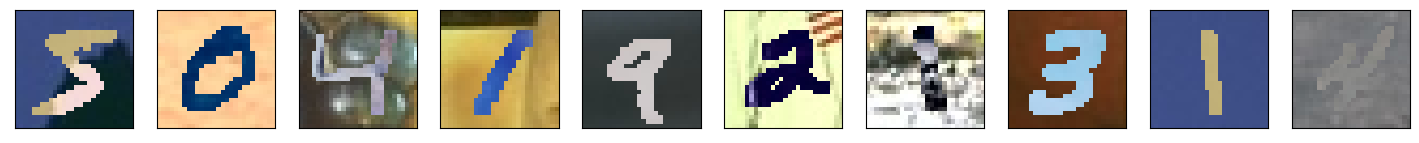

In [26]:
def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

# titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(os.path.join(mnist_data, f'{i+0:05d}.png')))

In [27]:
csv = pd.read_csv(usps_valid)
labels = [(name, label) for (name, label) in zip(csv['image_name'], csv['label'])]
# labels = [ label for label in csv['label']]
csv.head(3)
print(len(labels))

# label path -> .csv
# input path -> data

1488


In [28]:
class digitsDataset(Dataset):
    def __init__(self, inputPath, labelPath, resize=28):
        self.inputPath = inputPath
        self.transform = transforms.Compose([
            transforms.Resize((resize,resize)),
            # transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
        self.norm = transforms.Compose([
            transforms.Normalize(mean=(0.44, 0.44, 0.44), std=(0.19, 0.19, 0.19))
        ])
        self.pd = pd.read_csv(labelPath)
        self.csv = [(name, label) for (name, label) in zip(self.pd['image_name'], self.pd['label'])]
        
    def __getitem__(self, index):
        inputImage = Image.open(os.path.join(self.inputPath, self.csv[index][0]))
        label = int(self.csv[index][1])
        inputImage = self.transform(inputImage)
        inputImage = inputImage.expand(3, inputImage.data.shape[1], inputImage.data.shape[2])
        inputImage = self.norm(inputImage)
        
        return inputImage, label        
        
    def __len__(self):
        return len(self.csv)

In [34]:
mnistDataset = digitsDataset(mnist_data, mnist_label)
mnistValDataset = digitsDataset(mnist_data, mnist_valid)
uspsDataset = digitsDataset(usps_data, usps_label)
uspsValDataset = digitsDataset(usps_data, usps_valid)

print('# images in mnist train:', len(mnistDataset))
print('# images in mnist valid:', len(mnistValDataset))
print('# images in usps train:', len(uspsDataset))
print('# images in usps valid:', len(uspsValDataset))
    
mnist_train_loader = DataLoader(dataset=mnistDataset, batch_size=64, shuffle=True, num_workers=4)
mnist_val_loader = DataLoader(dataset=mnistValDataset, batch_size=4, shuffle=False, num_workers=0)
usps_train_loader = DataLoader(dataset=uspsDataset, batch_size=64, shuffle=True, num_workers=4)
usps_val_loader = DataLoader(dataset=uspsValDataset, batch_size=4, shuffle=False, num_workers=0)

dataiter = iter(mnist_val_loader)
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device used:', device)

# images in mnist train: 44800
# images in mnist valid: 11200
# images in usps train: 5950
# images in usps valid: 1488
Image tensor in each batch: torch.Size([4, 3, 28, 28]) torch.float32
Label tensor in each batch: torch.Size([4]) torch.int64
Device used: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:


IndexError: index 4 is out of bounds for dimension 0 with size 4

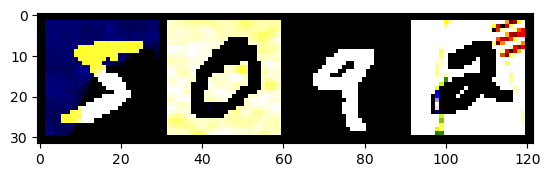

In [35]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(16)))

# Model


In [36]:
# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 1, 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(64, 128, 3, 1, 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(128, 256, 3, 1, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(256, 256, 3, 1, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(256, 512, 3, 1, 1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             # nn.MaxPool2d(2)
#         ) 
#     def forward(self, x):
#         # print("QQQQ= ", x.shape)
#         x = self.conv(x).squeeze()
#         # print("QAQ = ", x.shape)
#         return x

# class LabelPredictor(nn.Module):
#     def __init__(self):
#         super(LabelPredictor, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10),
#         )
#     def forward(self, h):
#         c = self.layer(h)
#         return c

# class DomainClassifier(nn.Module):

#     def __init__(self):
#         super(DomainClassifier, self).__init__()

#         self.layer = nn.Sequential(
#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 1),
#         )

#     def forward(self, h):
#         y = self.layer(h)
#         return y
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # nn.MaxPool2d(2)
        ) 
    def forward(self, x):
        # print("QQQQ= ", x.shape)
        x = self.conv(x).squeeze()
        # print("QAQ = ", x.shape)
        return x.flatten(1)

class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
    def forward(self, h):
        y = self.layer(h)
        return y

In [37]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Use GPU if available, otherwise stick with cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device used:', device)

Device used: cuda


In [39]:
from torchsummary import summary
summary(feature_extractor, (3, 28, 28), 10)
# summary(label_predictor, (512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [10, 64, 28, 28]           1,792
       BatchNorm2d-2           [10, 64, 28, 28]             128
              ReLU-3           [10, 64, 28, 28]               0
         MaxPool2d-4           [10, 64, 14, 14]               0
            Conv2d-5          [10, 128, 14, 14]          73,856
       BatchNorm2d-6          [10, 128, 14, 14]             256
              ReLU-7          [10, 128, 14, 14]               0
         MaxPool2d-8            [10, 128, 7, 7]               0
            Conv2d-9            [10, 256, 5, 5]         295,168
      BatchNorm2d-10            [10, 256, 5, 5]             512
             ReLU-11            [10, 256, 5, 5]               0
           Conv2d-12            [10, 256, 3, 3]         590,080
      BatchNorm2d-13            [10, 256, 3, 3]             512
             ReLU-14            [10, 25

In [19]:
# def train_epoch(source_dataloader, target_dataloader, usps_val_loader, lamb):
best_acc = 0
lamb = 0.2
for epoch in range(200):
    running_D_loss, running_F_loss = 0.0, 0.0
    mnist_acc, mnist_hit = 0, 0
    
    feature_extractor.train()
    label_predictor.train()
    domain_classifier.train()
    
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(mnist_train_loader, usps_train_loader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        optimizer_D.zero_grad()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        mnist_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        domain_logits = domain_classifier(feature)
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item() 
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        print(i, end='\r')
    mnist_acc = mnist_hit/min(len(mnist_train_loader.dataset), len(usps_train_loader.dataset))    
    with torch.no_grad():
        feature_extractor.eval()
        label_predictor.eval()
        acc, hit = 0, 0
        val_loss = 0
        for i , (val_data, val_label) in enumerate(usps_val_loader):
            val_data, val_label = val_data.cuda(), val_label.cuda()                
            class_logits = label_predictor(feature_extractor(val_data))
            val_loss += class_criterion(class_logits, val_label).item()                
            hit += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
            print(i, end='\r')
        acc = hit/len(usps_val_loader.dataset)
    print("epoch:{:3d}, Dloss:{:6.4f}, Floss:{:6.4f}, val_loss:{:6.4f}, mnist_acc:{:6.4f}, usps_acc:{:6.4f}".format(epoch+1, running_D_loss/(epoch+1), running_F_loss/(epoch+1), val_loss/(epoch+1), mnist_acc, acc))

    if acc > best_acc:
        torch.save(feature_extractor.state_dict(), os.path.join(ckpt_path, f'extractor.pth'))
        torch.save(label_predictor.state_dict(), os.path.join(ckpt_path, f'predictor.pth'))
        best_acc = acc
        print(f' | Save checkpoint to epoch{epoch+1}.')
    
# train_epoch(mnist_train_loader, usps_train_loader, usps_val_loader, lamb=0.2)


epoch:  1, Dloss:62.4695, Floss:14.6701, val_loss:375.3964, mnist_acc:0.9106, usps_acc:0.7500
 | Save checkpoint to epoch1.
epoch:  2, Dloss:31.5063, Floss:5.5401, val_loss:187.5862, mnist_acc:0.9257, usps_acc:0.7668
 | Save checkpoint to epoch2.
epoch:  3, Dloss:18.9482, Floss:2.5370, val_loss:86.2612, mnist_acc:0.9343, usps_acc:0.8306
 | Save checkpoint to epoch3.
epoch:  4, Dloss:14.1246, Floss:1.7235, val_loss:55.7211, mnist_acc:0.9385, usps_acc:0.8313
 | Save checkpoint to epoch4.
epoch:  5, Dloss:12.2596, Floss:0.9880, val_loss:45.3708, mnist_acc:0.9432, usps_acc:0.8555
 | Save checkpoint to epoch5.
epoch:  6, Dloss:9.5556, Floss:0.4601, val_loss:42.2566, mnist_acc:0.9563, usps_acc:0.8535
epoch:  7, Dloss:8.5828, Floss:0.4286, val_loss:42.1267, mnist_acc:0.9548, usps_acc:0.8434
epoch:  8, Dloss:7.6144, Floss:-0.0355, val_loss:27.7025, mnist_acc:0.9630, usps_acc:0.8474
epoch:  9, Dloss:6.7518, Floss:0.1243, val_loss:30.2014, mnist_acc:0.9582, usps_acc:0.8716
 | Save checkpoint to 

In [20]:
# Lower bound: train on source, evaluate on target
# def train_lowerbound(mnist_train_loader, usps_val_loader):

for epoch in range(35):
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    feature_extractor.train()
    label_predictor.train()
    for i, (source_data, source_label) in enumerate(mnist_train_loader):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        feature = feature_extractor(source_data)
        
        class_logits = label_predictor(feature)
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        
        loss = class_criterion(class_logits, source_label)
        running_F_loss+= loss.item()
        
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()            

    with torch.no_grad():
        feature_extractor.eval()
        label_predictor.eval()
        acc = 0.0
        val_loss = 0.0
        for i , (val_data, val_label) in enumerate(usps_val_loader):
            val_data, val_label = val_data.cuda(), val_label.cuda()                
            class_logits = label_predictor(feature_extractor(val_data))
            val_loss += class_criterion(class_logits, val_label).item()                
            acc += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
    print("epoch: {:2d}, Floss: {:6.4f}, val_loss: {:6.4f}, mnist_hit: {}, mnist_acc: {:6.4f}, usps hit: {}, usps_acc: {:6.4f}".format(epoch+1, running_F_loss, val_loss, total_hit, total_hit/total_num, acc, acc/len(usps_val_loader.dataset)))

epoch:  1, Floss: 20.3785, val_loss: 235.1556, mnist_hit: 44384.0, mnist_acc: 0.9907, usps hit: 1352.0, usps_acc: 0.9086
epoch:  2, Floss: 14.8707, val_loss: 175.5064, mnist_hit: 44507.0, mnist_acc: 0.9935, usps hit: 1369.0, usps_acc: 0.9200
epoch:  3, Floss: 14.1200, val_loss: 253.1637, mnist_hit: 44518.0, mnist_acc: 0.9937, usps hit: 1344.0, usps_acc: 0.9032
epoch:  4, Floss: 12.1394, val_loss: 269.2971, mnist_hit: 44556.0, mnist_acc: 0.9946, usps hit: 1335.0, usps_acc: 0.8972
epoch:  5, Floss: 12.1995, val_loss: 497.6331, mnist_hit: 44557.0, mnist_acc: 0.9946, usps hit: 1285.0, usps_acc: 0.8636
epoch:  6, Floss: 12.5914, val_loss: 448.0264, mnist_hit: 44564.0, mnist_acc: 0.9947, usps hit: 1290.0, usps_acc: 0.8669
epoch:  7, Floss: 13.1040, val_loss: 257.2705, mnist_hit: 44556.0, mnist_acc: 0.9946, usps hit: 1350.0, usps_acc: 0.9073
epoch:  8, Floss: 9.1577, val_loss: 281.5656, mnist_hit: 44628.0, mnist_acc: 0.9962, usps hit: 1289.0, usps_acc: 0.8663
epoch:  9, Floss: 8.2941, val_los

In [21]:
# Upper bound: train on target, evaluate on target 
# def train_upperbound(usps_train_loader, usps_val_loader):
for epoch in range(35):
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    feature_extractor.train()
    label_predictor.train()
    for i, (source_data, source_label) in enumerate(usps_train_loader):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        feature = feature_extractor(source_data)
        
        class_logits = label_predictor(feature)
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        loss = class_criterion(class_logits, source_label)
        running_F_loss+= loss.item()
        
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()      
        
    with torch.no_grad():
        feature_extractor.eval()
        label_predictor.eval()
        acc = 0.0
        val_loss = 0.0
        for i , (val_data, val_label) in enumerate(usps_val_loader):
            val_data, val_label = val_data.cuda(), val_label.cuda()                
            class_logits = label_predictor(feature_extractor(val_data))
            val_loss += class_criterion(class_logits, val_label).item()                
            acc += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
    print("epoch: {:2d}, Floss: {:6.4f}, val_loss: {:6.4f}, mnist_hit: {}, mnist_acc: {:6.4f}, usps hit: {}, usps_acc: {:6.4f}".format(epoch+1, running_F_loss, val_loss, total_hit, total_hit/total_num, acc, acc/len(usps_val_loader.dataset)))

# train_upperbound(usps_train_loader, usps_val_loader)

epoch:  1, Floss: 18.3088, val_loss: 46.6625, mnist_hit: 5690.0, mnist_acc: 0.9563, usps hit: 1445.0, usps_acc: 0.9711
epoch:  2, Floss: 4.8430, val_loss: 36.0054, mnist_hit: 5870.0, mnist_acc: 0.9866, usps hit: 1455.0, usps_acc: 0.9778
epoch:  3, Floss: 2.1043, val_loss: 42.9417, mnist_hit: 5912.0, mnist_acc: 0.9936, usps hit: 1457.0, usps_acc: 0.9792
epoch:  4, Floss: 1.6924, val_loss: 43.1932, mnist_hit: 5920.0, mnist_acc: 0.9950, usps hit: 1458.0, usps_acc: 0.9798
epoch:  5, Floss: 1.6280, val_loss: 35.0616, mnist_hit: 5925.0, mnist_acc: 0.9958, usps hit: 1464.0, usps_acc: 0.9839
epoch:  6, Floss: 0.8929, val_loss: 37.1196, mnist_hit: 5935.0, mnist_acc: 0.9975, usps hit: 1464.0, usps_acc: 0.9839
epoch:  7, Floss: 0.8443, val_loss: 33.8429, mnist_hit: 5936.0, mnist_acc: 0.9976, usps hit: 1462.0, usps_acc: 0.9825
epoch:  8, Floss: 0.4170, val_loss: 37.9404, mnist_hit: 5943.0, mnist_acc: 0.9988, usps hit: 1468.0, usps_acc: 0.9866
epoch:  9, Floss: 0.5756, val_loss: 42.5857, mnist_hit:

Start eval ....
hit: 1394, len: 1488, acc: 0.9368279569892473



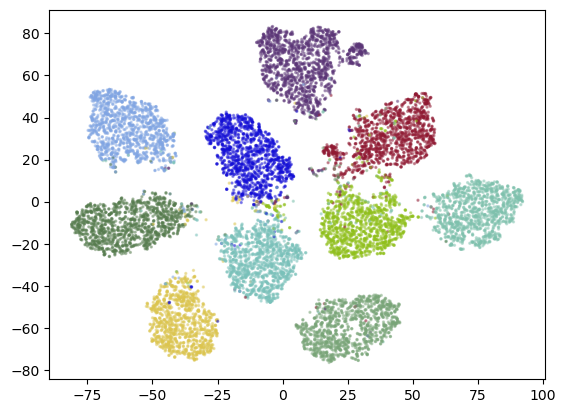

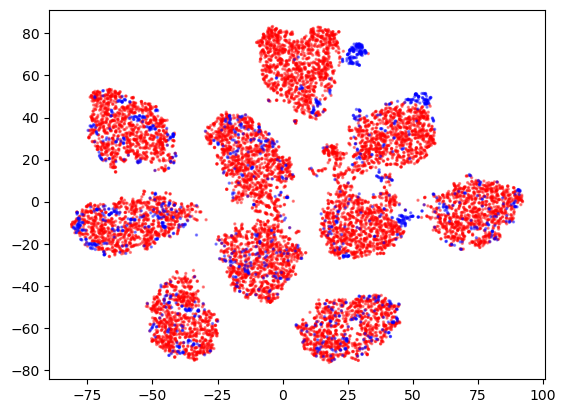

In [40]:
label_pred = LabelPredictor().cuda()
opt_C = optim.Adam(label_pred.parameters())
feat_extr = FeatureExtractor().cuda()
opt_F = optim.Adam(feat_extr.parameters())

label_pred.load_state_dict(torch.load(os.path.join(ckpt_path, './predictor.pth')))
feat_extr.load_state_dict(torch.load(os.path.join(ckpt_path, './extractor.pth')))
label_pred.eval()
feat_extr.eval()

colors = np.random.random((10, 3))
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
with torch.no_grad():
    outputs, labels, domains = [], [], []
    print("Start eval ....")
    result = []
    total_hit = 0
    total_num = 0
    val_loss = 0
    for i, (val_data, val_label) in enumerate(mnist_val_loader):
        val_data = val_data.cuda()
        val_label = val_label.cuda()
        feature = feat_extr(val_data)
        outputs.append(feature.cpu().numpy())
        labels.append(val_label.cpu())
        domains.append(np.ones(val_data.shape[0], dtype=np.int8))
        
    for i, (val_data, val_label) in enumerate(usps_val_loader):
        val_data = val_data.cuda()
        val_label = val_label.cuda()
        feature = feat_extr(val_data)
        outputs.append(feature.cpu().numpy())
        labels.append(val_label.cpu())
        domains.append(np.zeros(val_data.shape[0], dtype=np.int8))
        
        class_logits = label_pred(feat_extr(val_data))
        val_loss += class_criterion(class_logits, val_label).item()    
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
        total_num += val_data.shape[0]
    print("hit: {}, len: {}, acc: {}\n".format(total_hit, total_num, total_hit/total_num))

    outputs = np.concatenate(outputs, axis=0)
    labels = np.concatenate(labels, axis=0)
    domains = np.concatenate(domains, axis=0)
    tsne_proj = tsne.fit_transform(outputs)
    plt1, plt2 = plt.figure(1), plt.figure(2)
    ax1, ax2 = plt1.add_subplot(111), plt2.add_subplot(111)
    ax1.scatter(tsne_proj[:,0], tsne_proj[:,1], s=2, color=[tuple(colors[i]) for i in labels], alpha=0.4)
    ax2.scatter(tsne_proj[:,0], tsne_proj[:,1], s=2, color=['r' if i == 1 else 'b' for i in domains], alpha=0.4)
    plt.show()

In [14]:
label_pred = LabelPredictor().cuda()
opt_C = optim.Adam(label_pred.parameters())
feat_extr = FeatureExtractor().cuda()
opt_F = optim.Adam(feat_extr.parameters())

label_pred.load_state_dict(torch.load('./usps_predictor.pth'))
feat_extr.load_state_dict(torch.load('./usps_extractor.pth'))
label_pred.eval()
feat_extr.eval()

# colors = np.random.random((10, 3))
# tsne = TSNE(n_components=2, learning_rate='auto', init='random')
with torch.no_grad():
    outputs, labels, domains = [], [], []
    print("Start eval ....")
    result = []
    total_hit = 0
    total_num = 0
    val_loss = 0
    # for i, (val_data, val_label) in enumerate(mnist_val_loader):
    #     val_data = val_data.cuda()
    #     val_label = val_label.cuda()
    #     feature = feat_extr(val_data)
    #     outputs.append(feature.cpu().numpy())
    #     labels.append(val_label.cpu())
    #     domains.append(np.ones(val_data.shape[0], dtype=np.int8))
        
    for i, (val_data, val_label) in enumerate(usps_val_loader):
        val_data = val_data.cuda()
        val_label = val_label.cuda()
        feature = feat_extr(val_data)
        outputs.append(feature.cpu().numpy())
        labels.append(val_label.cpu())
        domains.append(np.zeros(val_data.shape[0], dtype=np.int8))
        
        class_logits = label_pred(feat_extr(val_data))
        val_loss += class_criterion(class_logits, val_label).item()    
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
        total_num += val_data.shape[0]
    print("hit: {}, len: {}, acc: {}\n".format(total_hit, total_num, total_hit/total_num))

    # outputs = np.concatenate(outputs, axis=0)
    # labels = np.concatenate(labels, axis=0)
    # domains = np.concatenate(domains, axis=0)
    # tsne_proj = tsne.fit_transform(outputs)
    # plt1, plt2 = plt.figure(1), plt.figure(2)
    # ax1, ax2 = plt1.add_subplot(111), plt2.add_subplot(111)
    # ax1.scatter(tsne_proj[:,0], tsne_proj[:,1], s=2, color=[tuple(colors[i]) for i in labels], alpha=0.4)
    # ax2.scatter(tsne_proj[:,0], tsne_proj[:,1], s=2, color=['r' if i == 1 else 'b' for i in domains], alpha=0.4)
    # plt.show()

Start eval ....
hit: 1421, len: 1488, acc: 0.9549731182795699



# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [116]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(loaderTargetVal):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

有任何問題 Domain Adaptation 的問題可以寄信到ntu-ml-2021spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在 2019FALL 的 ML Final Project，以下是我認為在 Final Report 不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
